### Know the data

#### This dataset describes 5-star(0.5-5.0) rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. 

#### It contains 100004 ratings and 1296 tag applications across 9125 movies. 
#### These data were created by 671 users between January 09, 1995 and October 16, 2016.
#### This dataset was generated on October 17, 2016.

#### Users were selected at random for inclusion. All selected users had rated at least 20 movies.

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

### Data Processing

#### upload data

In [2]:
df_moives = pd.read_csv('data-ml-latest-small/movies.csv',index_col='movieId')

In [3]:
df_moives.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings = pd.read_csv('data-ml-latest-small/ratings.csv')

In [5]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
data = pd.merge(df_moives, df_ratings, left_index=True, right_on='movieId')
#use left index as join key,default inner join 

In [7]:
data.head()

,title,genres,userId,movieId,rating,timestamp
495,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,1,3.0,851866703
699,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,1,4.0,938629179
889,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,1,5.0,1331380058
962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,1,2.0,997938310
3105,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,1,3.0,855190091


In [8]:
data.shape

(100004, 6)

#### Create movie-rating matrix

In [9]:
user_movie = data.pivot_table(index = ["userId"],columns = ["movieId"],values = "rating")

In [10]:
user_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
user_movie.shape

(671, 9066)

In [86]:
sparsity = user_movie.notnull().sum().sum()/(user_movie.shape[0]*user_movie.shape[1])

In [87]:
sparsity

0.016439141608663475

In [91]:
sparsity *= 100 #want print using %

In [92]:
print ('Sparsity: {:4.2f}%'.format(sparsity)) 

Sparsity: 1.64%


In [15]:
ratings_mat = user_movie.fillna(0).as_matrix()

E:\downloads\Anaconada\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


#### split train, test set

In [16]:
def train_val_split(ratings):
    val = np.zeros(ratings.shape) 
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=int(len(ratings[user, :].nonzero()[0])*0.2), 
                                        replace=False)
    
        train[user, val_ratings] = 0. #substitute 0 into the validation selected entries in training data
        val[user, val_ratings] = ratings[user, val_ratings] #build validation matrix dataset
        
    # val and training are truly disjoint
    assert(np.all((train * val) == 0))  #since train[user,val_ratings]=0
    return train, val

#### Continue split train and val dataset

In [27]:
train, val = train_val_split(ratings_mat)

In [28]:
train.shape

(671, 9066)

In [29]:
val.shape

(671, 9066)

#### Generate cosine similarity matrix

In [30]:
def cos_similarity(ratings, kind='user', epsilon=1e-9):
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'movie':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [31]:
user_similarity = cos_similarity(train, kind='user') #user based
movie_similarity=cos_similarity(train, kind='movie') #item based

In [32]:
user_similarity.shape

(671, 671)

In [33]:
movie_similarity.shape

(9066, 9066)

### Recommendation system 1: Based on Centered cosine similarity only

#### predict the user ratings based on the similarity matrix

In [42]:
def slow_predict(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape) # if rating is mxn
    if kind == 'user':
        user_bias = ratings.mean(axis=1)#calculate mean for each row(each individual user),result is 1xm vector
        ratings = (ratings - user_bias[:, np.newaxis]).copy() #each entry(rating score) - mean rating score
        user_bias[:, np.newaxis] is mx1 matrix
       
        for i in range(ratings.shape[0]):  #m
            for j in range(ratings.shape[1]): #n
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :])) #calculate predicted rating score of user i to j movie
        pred += user_bias[:, np.newaxis] # get the vallue in the range 0 to 5
    elif kind == 'movie':
        movie_bias = ratings.mean(axis=0)#calculate mean for each col(each individual movie),result is 1xn
        ratings = (ratings - movie_bias[np.newaxis, :]).copy()
        for i in range(ratings.shape[0]):#n
            for j in range(ratings.shape[1]):#m
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :])) #calculate predicted rating score of user i to j movie
        pred += movie_bias[np.newaxis, :]
    return pred

In [43]:
#use matrix.dot (the matix product) more efficient
def fast_predict(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'movie':
        movie_bias = ratings.mean(axis=0)
        ratings = (ratings - movie_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += movie_bias[np.newaxis, :]
         
    return pred

In [53]:
#test the time of the fast process
%timeit user_prediction_fast = fast_predict(train, user_similarity, kind='user')

190 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
#test the time of the slow process
%timeit user_prediction_slow = slow_predict(train, user_similarity, kind='user')

58.5 s ± 912 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### evaluate the training machine's performance using MSE

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() #pick the elements in prediction whose position is the same as the nonzero element in the ground_truth matirx.
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()#pick up nonzero element in ground_truth
    return sqrt(mean_squared_error(prediction, ground_truth)) #get the MSE between predicted values and the corresponding true value

In [63]:
print ('User-based bias-adjusted CF RMSE: %.2f' %rmse(user_prediction_fast, val))
print ('Movie-based bias-adjusted CF RMSE: %.2f' %rmse(movie_prediction_fast, val))

User-based bias-adjusted CF RMSE: 3.21
Movie-based bias-adjusted CF RMSE: 3.24


#### evaluate the performance by compararing the top 10 predicted and actual movie for each user

In [64]:
movie_id_list = user_movie.columns

In [68]:
movie_id_title = df_moives.title

In [70]:
#define a comparison function
def get_user_topn_movies(userid, pred,val,n, movie_id_list=movie_id_list, movie_id_tilte=movie_id_tilte):
    val_topn_rating = sorted(val[userid,][val[userid,].nonzero()], reverse=True)[:n]#choose all nonzero elements(rating scores) in each row(user),and sort them in Desc order, then get the first n. 
    val_topn = val[userid,][val[userid,].nonzero()].argsort()[::-1][:n] #the same as val_topn_rating, but return the indices of the movie
    pred_topn_rating = sorted(pred[userid,][val[userid,].nonzero()], reverse=True)[:n]
    pred_topn = pred[userid,][val[userid,].nonzero()].argsort()[::-1][:n]
    val_movies = movie_id_tilte[movie_id_list[val_topn]].values #get the actual topn movie names
    pred_movies = movie_id_tilte[movie_id_list[pred_topn]].values#get the actual topn movie names
    compare = pd.DataFrame({'prediction topn':pred_movies,
                            'prediction ratings':pred_topn_rating,
                            'actual topn':val_movies,
                            'actual ratings':val_topn_rating})
    return compare

#sort:efficiency, log(n)

In [71]:
get_user_topn_movies(userid=48, pred=user_prediction_fast,val=val,n=10) 

,prediction topn,prediction ratings,actual topn,actual ratings
0,Waiting to Exhale (1995),1.669183,GoldenEye (1995),5.0
1,Father of the Bride Part II (1995),1.403499,Heat (1995),5.0
2,Jumanji (1995),1.171668,Waiting to Exhale (1995),4.0
3,Toy Story (1995),1.064059,Sense and Sensibility (1995),4.0
4,GoldenEye (1995),0.682165,Casino (1995),4.0
5,Heat (1995),0.445942,Cutthroat Island (1995),4.0
6,Tom and Huck (1995),0.332996,"American President, The (1995)",4.0
7,Sabrina (1995),0.328345,Jumanji (1995),4.0
8,Grumpier Old Men (1995),0.282923,Nixon (1995),3.0
9,Sudden Death (1995),0.282361,Balto (1995),3.0


In [72]:
get_user_topn_movies(userid=48, pred=movie_prediction_fast,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Waiting to Exhale (1995),1.156878,GoldenEye (1995),5.0
1,Father of the Bride Part II (1995),0.934489,Heat (1995),5.0
2,Jumanji (1995),0.835363,Waiting to Exhale (1995),4.0
3,Toy Story (1995),0.756693,Sense and Sensibility (1995),4.0
4,GoldenEye (1995),0.402557,Casino (1995),4.0
5,Heat (1995),0.223440,Cutthroat Island (1995),4.0
6,Sabrina (1995),0.203979,"American President, The (1995)",4.0
7,Tom and Huck (1995),0.185726,Jumanji (1995),4.0
8,Grumpier Old Men (1995),0.151042,Nixon (1995),3.0
9,Sudden Death (1995),0.149643,Balto (1995),3.0


### Recommendation system 2: using SVD matrix factorization

In [73]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [74]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train, k = 7)
s_diag_matrix=np.diag(s)
SVD_X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [75]:
print ('matrix-factorization CF RMSE: %.2f' %rmse(SVD_X_pred, val))

matrix-factorization CF RMSE: 3.00


In [76]:
get_user_topn_movies(userid=48, pred=SVD_X_pred,val=val,n=10)
#better than cosine similarity matrix

,prediction topn,prediction ratings,actual topn,actual ratings
0,Waiting to Exhale (1995),1.337848,GoldenEye (1995),5.0
1,Father of the Bride Part II (1995),1.068333,Heat (1995),5.0
2,Heat (1995),0.547473,Waiting to Exhale (1995),4.0
3,Jumanji (1995),0.507576,Sense and Sensibility (1995),4.0
4,GoldenEye (1995),0.422772,Casino (1995),4.0
5,Toy Story (1995),0.391063,Cutthroat Island (1995),4.0
6,Sense and Sensibility (1995),0.307002,"American President, The (1995)",4.0
7,Dracula: Dead and Loving It (1995),0.300950,Jumanji (1995),4.0
8,Cutthroat Island (1995),0.297752,Nixon (1995),3.0
9,Sudden Death (1995),0.280649,Balto (1995),3.0


### Recommendation system 3: using Funk SVD

In [77]:
#P is latent user feature matrix
#Q is latent movie feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [78]:
lam = 0.3 
k = 7 
m, n = train.shape 
n_epochs = 100  
alpha=0.01  # Learning rate

P = 5 * np.random.rand(k,m) # get a initial random matrix as Latent user feature matrix, multiply 5:make sure the value in the matrix is in the range(0,5)
Q = 5 * np.random.rand(k,n) # Latent movie feature matrix

In [80]:
#get P, Q for funkSVD with 100 iteratives 
train_errors = []
val_errors = []

#Only consider movies with ratings 
users,movies = train.nonzero() 
for epoch in range(n_epochs):
    for u, i in zip(users,movies):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lam * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lam * Q[:,i])  # Update latent movie feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
    if epoch%10==0:
        print('finish epoch: %d' %epoch) #visualize the itterative process each 10 steps

finish epoch: 0
finish epoch: 10
finish epoch: 20
finish epoch: 30
finish epoch: 40
finish epoch: 50
finish epoch: 60
finish epoch: 70
finish epoch: 80
finish epoch: 90


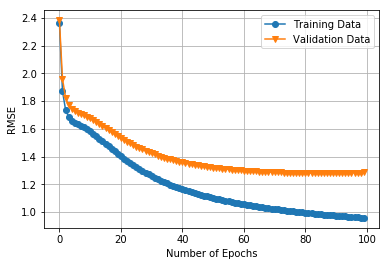

In [81]:
#to visulize the change of train_rmse and val_rmse in the 100 iterative
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()
#the result show 100 itterative is enough to converge the results, 
#and the mse is very small,1.3 for val, 0.7 for train

In [82]:
#get prediction model using FunkSVD method
Funk_prediction=prediction(P,Q)

In [83]:
#make prediction
funk_pred= Funk_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':funk_pred, 'actual rating':ground_truth})
results.head(15)

,prediction,actual rating
0,2.190731,2.5
1,2.234118,2.0
2,2.647759,4.0
3,2.547748,1.0
4,3.026272,4.0
5,3.410857,5.0
6,4.060545,4.0
7,3.207493,3.0
8,3.603140,3.0
9,3.445807,4.0


In [84]:
get_user_topn_movies(userid=48, pred=Funk_prediction,val=val,n=10)

,prediction topn,prediction ratings,actual topn,actual ratings
0,Waiting to Exhale (1995),3.735738,GoldenEye (1995),5.0
1,Casino (1995),3.728342,Heat (1995),5.0
2,Sense and Sensibility (1995),3.722711,Waiting to Exhale (1995),4.0
3,Dracula: Dead and Loving It (1995),3.654476,Sense and Sensibility (1995),4.0
4,Heat (1995),3.566612,Casino (1995),4.0
5,Father of the Bride Part II (1995),3.523491,Cutthroat Island (1995),4.0
6,Cutthroat Island (1995),3.497358,"American President, The (1995)",4.0
7,GoldenEye (1995),3.382810,Jumanji (1995),4.0
8,Sudden Death (1995),3.219286,Nixon (1995),3.0
9,Jumanji (1995),3.124006,Balto (1995),3.0
